In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import pandas as pd
np.random.seed(0)
%matplotlib inline

In [90]:


# generate skwed data (the ratio of class 1 to class 0 is defined by weights)
X, y = datasets.make_classification(n_samples=10000, n_features=10,
                                    n_informative=2, n_redundant=2,
                                    weights = [0.8]
                                    )
# use 60% of the data for training
train_ratio = 0.6
train_samples = int(len(y) * train_ratio)

X_train = X[:train_samples]
X_test = X[train_samples:]
y_train = y[:train_samples]
y_test = y[train_samples:]

counts = pd.DataFrame(columns=["nrows", "ncols", "nrows_C0", "nrows_C1", "ratio_C1_to_C0"], index=["data", "training", "testing"])
counts.loc["data",] = [X.shape[0], X.shape[1], sum(y==0), sum(y==1), 1.*sum(y==1)/sum(y==0)]
counts.loc["training",] = [X_train.shape[0], X_train.shape[1], sum(y_train==0), sum(y_train==1), 1.*sum(y_train==1)/sum(y_train==0)]
counts.loc["testing",] = [X_test.shape[0], X_test.shape[1], sum(y_test==0), sum(y_test==1), 1.*sum(y_test==1)/sum(y_test==0)]

counts

,nrows,ncols,nrows_C0,nrows_C1,ratio_C1_to_C0
data,10000,10,7970,2030,0.2547051
training,6000,10,4765,1235,0.2591815
testing,4000,10,3205,795,0.2480499


# Classification using scikit-learn

In [91]:
# Create classifiers
sklear_lr = LogisticRegression()
sklear_lr.fit(X_train, y_train)
predicted = sklear_lr.predict(X_test)
probs = sklear_lr.predict_proba(X_test)

print "accuracy: ", metrics.accuracy_score(y_test, predicted)
print "confusion matrix"
pd.DataFrame(metrics.confusion_matrix(y_test, predicted))

accuracy:  0.947
confusion matrix


,0,1
0,3089,116
1,96,699


In [92]:
metrics.classification_report(y_test, predicted)

pd.DataFrame(np.asarray(
        metrics.precision_recall_fscore_support(y_test, predicted)),
             index = ["PPV", "TPR", "F1Measure", "support"]
            )

,0,1
PPV,0.969859,0.857669
TPR,0.963807,0.879245
F1Measure,0.966823,0.868323
support,3205.000000,795.000000


In [93]:
pd.DataFrame([metrics.mean_squared_error(y_test, predicted),
    1-metrics.roc_auc_score(y_test, probs[:,1]),
    metrics.log_loss(y_test, probs)], 
    index=["MSE", "auc loss", "log-loss"])

,0
MSE,0.053000
auc loss,0.026149
log-loss,0.153898


In [94]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

# Create classifiers
lr = LogisticRegression()
gnb = GaussianNB()
svc = LinearSVC(C=1.0)
rfc = RandomForestClassifier(n_estimators=100)

probs_df = pd.DataFrame(columns=["Logistic",
                                "Naive Bayes",
                                'Support Vector Classification',
                                'Random Forest'])
loss_df = pd.DataFrame(columns=["Logistic",
                                "Naive Bayes",
                                'Support Vector Classification',
                                'Random Forest'],
                      index=["Accuracy", "auc", "log score", "PPV", "TPR", "F1Measure"])
for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive Bayes'),
                  (svc, 'Support Vector Classification'),
                  (rfc, 'Random Forest')]:
    clf.fit(X_train, y_train)
    predicted = clf.predict(X_test)
    if hasattr(clf, "predict_proba"):
        probs = clf.predict_proba(X_test)
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        probs = np.array([1-prob_pos,prob_pos]).T
    probs_df[name] = probs[:,1]
    loss_df[name] = pd.DataFrame([metrics.accuracy_score(y_test, predicted),
                                  metrics.roc_auc_score(y_test, probs[:,1]),
                                  1-metrics.log_loss(y_test, probs),
                                  metrics.precision_score(y_test, predicted),
                                  metrics.recall_score(y_test, predicted),
                                  metrics.f1_score(y_test, predicted)], 
                                  index=["Accuracy", "auc", "log score", "PPV", "TPR", "F1Measure"])

In [95]:
 loss_df

,Logistic,Naive Bayes,Support Vector Classification,Random Forest
Accuracy,0.947000,0.946250,0.946000,0.956750
auc,0.973851,0.976480,0.973418,0.981453
log score,0.846102,0.845107,0.533785,0.800197
PPV,0.857669,0.831808,0.851762,0.876513
TPR,0.879245,0.914465,0.881761,0.910692
F1Measure,0.868323,0.871180,0.866502,0.893276


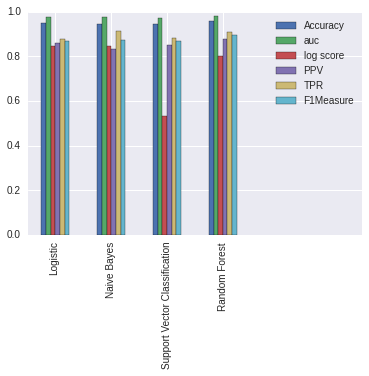

In [96]:
ax = loss_df.T.plot(kind="bar", xlim=[-0.5,5.5])

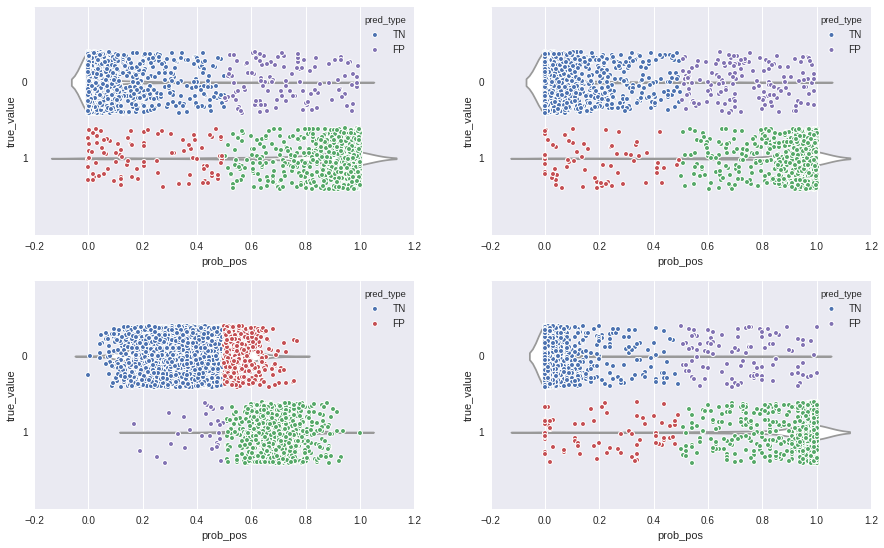

In [97]:
from ggplot import *
import seaborn as sns
# sns.set_style("whitegrid")

def plot_pred_type_distribution(prob_pos, true_value, threshold, ax=None):
    df = pd.DataFrame(columns=["prob_pos", "true_value", "pred_type"])
    df.prob_pos = prob_pos
    df.true_value = true_value
    
    #v = pd.DataFrame(np.zeros((len(prob_pos),1)))

    df.loc[(df.prob_pos >= threshold) & (df.true_value == 1),"pred_type"] = "TP"
    df.loc[(df.prob_pos >= threshold) & (df.true_value == 0),"pred_type"] = "FP" 
    df.loc[(df.prob_pos <  threshold) & (df.true_value == 1),"pred_type"] = "FN" 
    df.loc[(df.prob_pos <  threshold) & (df.true_value == 0),"pred_type"] = "TN"
  
    ax = sns.violinplot(x="prob_pos", y="true_value", data=df, inner=None, 
                        color='#FFFFFF', orient="h", scale="count", ax=ax)
    ax = sns.stripplot(x="prob_pos", y="true_value", data=df, size=5,
                       orient="h", hue="pred_type", split= False, 
                       jitter=0.4, ax=ax)
    ax.set_ylim(2,-1)
#     p = ggplot(aes(x="true_value", y="prob_pos"), data=df)
#     # p += geom_violin(fill=rgb(1,1,1,alpha=0.6), color=None) 
#     p += geom_jitter(x="true_value", y="prob_pos", color="pred_type", alpha=0.6) 
#     p += geom_hline(yintercept=threshold, color="red", alpha=0.6) 
#     p += scale_color_brewer(name = "type") 
#     p += labs(title=("Threshold at %.2f" % threshold))
#     return p

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(15, 9)

plot_pred_type_distribution(probs_df["Logistic"], y_test, 0.5, ax1)
plot_pred_type_distribution(probs_df["Naive Bayes"], y_test, 0.5, ax2)
plot_pred_type_distribution(probs_df["Support Vector Classification"], y_test, 0.5, ax3)
plot_pred_type_distribution(probs_df["Random Forest"], y_test, 0.5, ax4)